In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import matplotlib.pyplot as plt
device = torch.device("cpu")

# Set a random seed so later our outputs dont keep changing
torch.manual_seed(42)

In [ ]:
# get tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Load gpt-2
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
model.eval()

In [82]:

"""
i want to investigate which neurons are responsible for subject verb agreement
so just adding in some simple test cases for that here. 
"""



agreement_sentences = [
    ("The cat", " is"),
    ("The cats", " are"),
    ("The boy", " is"),
    ("The boys", " are"),
    ("The dog", " is"),
    ("The dogs", " are")
]

print("Prompts for subject verb agreement:")
for prompt, correct in agreement_sentences:
    print(f"  {prompt!r} → should prefer {correct!r}")

Prompts for subject verb agreement:
  'The cat' → should prefer ' is'
  'The cats' → should prefer ' are'
  'The boy' → should prefer ' is'
  'The boys' → should prefer ' are'
  'The dog' → should prefer ' is'
  'The dogs' → should prefer ' are'


In [ ]:
# Get the baseline so we can compare to after we introduce noise
baseline_probs = []

for prompt, correct in agreement_sentences:
    # tokenize the prompt + a space if needed
    text = prompt + " "
    inputs = tokenizer(text, return_tensors="pt").to(device)

    # run forward pass (no intervention yet!)
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits[0]  # remove batch dim since it's always 1

    # get ids for both the correct and incorrect next tokens
    # correct is like " is" and incorrect would be the opposite
    correct_id = tokenizer.encode(correct.strip(), add_special_tokens=False)[0]

    # we pick one obvious incorrect opposite: if correct is "is", pick "are" and vice versa
    wrong = " are" if correct.strip() == "is" else " is"
    wrong_id = tokenizer.encode(wrong.strip(), add_special_tokens=False)[0]

    # probability of correct vs wrong using softmax
    probs = torch.softmax(logits[-1], dim=-1)
    correct_prob = probs[correct_id].item()
    wrong_prob = probs[wrong_id].item()

    baseline_probs.append((prompt, correct, correct_prob, wrong_prob))

    # i need to print to more decimals to see which option the model prefers, because it obviously
    # spread its probability among many thousands of possible next tokens
    print(f"{prompt!r}: P({correct.strip()}) = {correct_prob:.6f}, "
      f"P({wrong.strip()}) = {wrong_prob:.6f}")

'The cat': P(is) = 0.000081, P(are) = 0.000003
'The cats': P(are) = 0.000011, P(is) = 0.000026
'The boy': P(is) = 0.000070, P(are) = 0.000002
'The boys': P(are) = 0.000004, P(is) = 0.000028
'The dog': P(is) = 0.000078, P(are) = 0.000002
'The dogs': P(are) = 0.000008, P(is) = 0.000024


In [ ]:
# Define the same agreement prompts
prompts = [
    ("The cat", "is", "are"),
    ("The cats", "are", "is"),
    ("The boy", "is", "are"),
    ("The boys", "are", "is"),
]

num_neurons = 500 # p sure the upper bound is 3072, so i can up this in future runs to check on things
avg_deltas = []

print("Testing neurons...")

# Get the MLP layer we want to intervene on
mlp_layer = model.transformer.h[0].mlp.c_fc

for neuron_idx in range(num_neurons):
    # Average delta_P(correct) across prompts
    deltas = []
    
    for prompt, correct, wrong in prompts:
        tok = tokenizer(prompt, return_tensors="pt").to(device)
        
        # Get baseline probabilities (without intervention)
        with torch.no_grad():
            base_out = model(**tok)
        base_logits = base_out.logits[0, -1]
        base_probs = torch.softmax(base_logits, dim=-1)
        
        correct_id = tokenizer.encode(" " + correct, add_special_tokens=False)[0]
        base_corr = base_probs[correct_id].item()
        
        # Get intervened probabilities - zero out this specific neuron
        def intervention_hook(module, input, output):
            # output shape: [batch, seq_len, hidden_size]
            output[:, :, neuron_idx] = 0.0
            return output
        
        handle = mlp_layer.register_forward_hook(intervention_hook)
        
        with torch.no_grad():
            int_out = model(**tok)
        
        handle.remove()  # Remove the hook
        
        int_logits = int_out.logits[0, -1]
        int_probs = torch.softmax(int_logits, dim=-1)
        int_corr = int_probs[correct_id].item()
        
        deltas.append(base_corr - int_corr)

    avg_delta = sum(deltas) / len(deltas)
    avg_deltas.append(avg_delta)
    
    # Print the effect for this neuron
    #print(f"Neuron {neuron_idx:4d}: ΔP(correct) = {avg_delta:+.6f}")

Testing neurons...


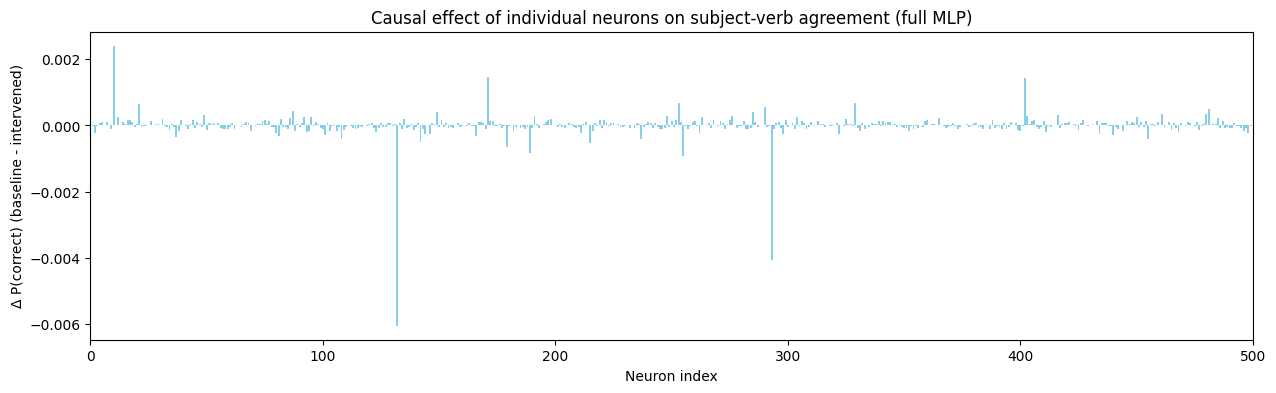


Top 10 neurons with largest |ΔP(correct)|:
Neuron 132: ΔP(correct) = -0.006058
Neuron 293: ΔP(correct) = -0.004067
Neuron 10: ΔP(correct) = +0.002412
Neuron 171: ΔP(correct) = +0.001460
Neuron 402: ΔP(correct) = +0.001450
Neuron 255: ΔP(correct) = -0.000916
Neuron 189: ΔP(correct) = -0.000838
Neuron 329: ΔP(correct) = +0.000692
Neuron 253: ΔP(correct) = +0.000670
Neuron 21: ΔP(correct) = +0.000654


In [88]:
# graph

import matplotlib.pyplot as plt
import numpy as np

avg_deltas = np.array(avg_deltas)
neuron_indices = np.arange(len(avg_deltas))

# Plot
plt.figure(figsize=(15,4))
plt.bar(neuron_indices, avg_deltas, color='skyblue')
plt.xlabel("Neuron index")
plt.ylabel("Δ P(correct) (baseline - intervened)")
plt.title("Causal effect of individual neurons on subject-verb agreement (full MLP)")
plt.xlim(0, len(neuron_indices))
plt.show()

# for debug, this just highlights the top 10 most impactful neurons
top_k = min(10, len(avg_deltas))
top_indices = np.argsort(np.abs(avg_deltas))[-top_k:][::-1]
print(f"\nTop {top_k} neurons with largest |ΔP(correct)|:")
for idx in top_indices:
    print(f"Neuron {idx}: ΔP(correct) = {avg_deltas[idx]:+.6f}")